# Goal

* A basic, full run of the SIPSim pipeline with the whole bacterial genome dataset to see:
  * Does it work?
  * Does the output as each stage look OK?

# Setting variables

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/validation/'
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

# Init

In [117]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Simulating fragments

In [9]:
%time !cd $workDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

CPU times: user 1.39 s, sys: 192 ms, total: 1.58 s
Wall time: 7min 18s


## Number of amplicons per taxon

In [10]:
!cd $workDir; \
    grep "Number of amplicons: " ampFrags.log | perl -pe 's/.+ +//' | hist


 424|  o        
 402|  o        
 380|  o        
 358|  o        
 335|  o        
 313|  o        
 291|  o        
 269|  o        
 246|  o        
 224|  o        
 202|  o        
 180| oo o      
 157| oooo      
 135| oooo      
 113| oooo      
  91| oooo      
  68| ooooo     
  46|ooooooo    
  24|ooooooo    
   2|ooooooooooo
     ----------------------

------------------------------
|          Summary           |
------------------------------
|     observations: 1210     |
|    min value: 0.000000     |
|      mean : 3.646281       |
|    max value: 16.000000    |
------------------------------


# Converting fragments to kde object

In [11]:
%time !cd $workDir; \
    SIPSim fragment_kde \
    ampFrags.pkl \
    > ampFrags_kde.pkl

CPU times: user 148 ms, sys: 16 ms, total: 164 ms
Wall time: 33.9 s


# Adding diffusion

In [12]:
%time !cd $workDir; \
    SIPSim diffusion \
    ampFrags_kde.pkl \
    --np 24 \
    > ampFrags_kde_dif.pkl    

Processing: Vibrio_vulnificus_MO6-24_O
Processing: Dyella_japonica_A8
Processing: Citrobacter_koseri_ATCC_BAA-895
Processing: Leisingera_methylohalidivorans_DSM_14336
Processing: Arthrobacter_arilaitensis_Re117
Processing: Veillonella_parvula_DSM_2008
Processing: Rhodococcus_jostii_RHA1
Processing: Croceibacter_atlanticus_HTCC2559
Processing: Corynebacterium_diphtheriae_C7_beta
Processing: Borrelia_burgdorferi_ZS7
Processing: Desulfovibrio_salexigens_DSM_2638
Processing: Glaciecola_psychrophila_170
Processing: Mycoplasma_haemocanis_str_Illinois
Processing: Hyphomicrobium_nitrativorans_NL23
Processing: Pedobacter_heparinus_DSM_2366
Processing: Candidatus_Rickettsia_amblyommii_str_GAT-30V
Processing: Beutenbergia_cavernae_DSM_12333
Processing: Chlorobaculum_parvum_NCIB_8327
Processing: Spiroplasma_diminutum_CUAS-1
Processing: Bifidobacterium_adolescentis_ATCC_15703
Processing: Morganella_morganii_subsp_morganii_KT
Processing: Klebsiella_pneumoniae_30660_NJST258_1
Processing: Meiothermus_

# Creating a community file

In [94]:
%time !cd $workDir; \
    SIPSim gradientComms \
    $genomeDir/genome_index.txt \
    --n_comm 2 \
    > comm.txt

CPU times: user 0 ns, sys: 16 ms, total: 16 ms
Wall time: 999 ms


## Plotting community rank abundances

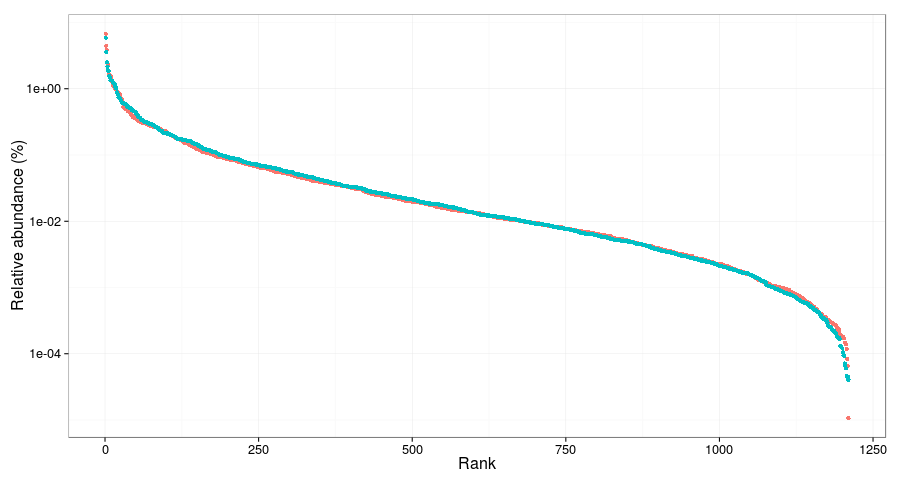

In [95]:
%%R -w 900 -i workDir

setwd(workDir)

tbl = read.delim('comm.txt', sep='\t')

tbl$library = as.character(tbl$library)

ggplot(tbl, aes(rank, rel_abund_perc, color=library, group=taxon_name)) +
    geom_point() +
    scale_y_log10() +
    labs(x='Rank', y='Relative abundance (%)') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        legend.position='none'
        )

# Making an incorp config file

In [29]:
%time !cd $workDir; \
    SIPSim incorpConfigExample \
    --percTaxa 25 \
    --percIncorpUnif 100 \
    > PT25_PI100.config

CPU times: user 0 ns, sys: 12 ms, total: 12 ms
Wall time: 553 ms


# Adding isotope incorporation to BD distribution

In [30]:
%time !cd $workDir; \
    SIPSim isoIncorp \
    ampFrags_kde_dif.pkl \
    PT25_PI100.config \
    --comm comm.txt \
    --np 24 \
    > ampFrags_kde_dif_incorp.pkl

Processing: Vibrio_vulnificus_MO6-24_O
Processing: Dyella_japonica_A8
Processing: Citrobacter_koseri_ATCC_BAA-895
Processing: Magnetospirillum_gryphiswaldense_MSR-1_v2
Processing: Arthrobacter_arilaitensis_Re117
Processing: Veillonella_parvula_DSM_2008
Processing: Rhodococcus_jostii_RHA1
Processing: Caldisericum_exile_AZM16c01
Processing: Spiroplasma_taiwanense_CT-1
Processing: Corynebacterium_halotolerans_YIM_70093_DSM_44683
Processing: Actinoplanes_missouriensis_431
Processing: Borrelia_burgdorferi_ZS7
Processing: Klebsiella_pneumoniae_30660_NJST258_1
Processing: Desulfovibrio_salexigens_DSM_2638
Processing: Enterococcus_faecalis_D32
Processing: Enterococcus_casseliflavus_EC20
Processing: Glaciecola_psychrophila_170
Processing: Chromobacterium_violaceum_ATCC_12472
Processing: Mycoplasma_wenyonii_str_Massachusetts
Processing: Caldicellulosiruptor_lactoaceticus_6A
Processing: Haemophilus_somnus_129PT
Processing: Streptococcus_sanguinis_SK36
Processing: Alkalilimnicola_ehrlichii_MLHE-1


# Calculating BD shift from isotope incorporation

In [146]:
%time !cd $workDir; \
    SIPSim BD_shift \
    ampFrags_kde_dif.pkl \
    ampFrags_kde_dif_incorp.pkl \
    --np 8 \
    > ampFrags_kde_dif_incorp_BD-shift.txt

Loading KDE objects...
Calculating BD shifts...
  Comparing libraries; "NA", "1"
  Processing: Vibrio_vulnificus_MO6-24_O
  Processing: Caldisericum_exile_AZM16c01
  Processing: Spiroplasma_taiwanense_CT-1
  Processing: Thermoanaerobacter_wiegelii_Rt8_B1
  Processing: Anabaena_cylindrica_PCC_7122
  Processing: Haemophilus_parainfluenzae_T3T1
  Processing: Burkholderia_rhizoxinica_HKI_454
  Processing: Delftia_acidovorans_SPH-1
  Processing: Leisingera_methylohalidivorans_DSM_14336
  Processing: Prosthecochloris_aestuarii_DSM_271
  Processing: Candidatus_Blochmannia_chromaiodes_str_640
  Processing: Methylovorus_glucosetrophus_SIP3-4
  Processing: Desulfovibrio_vulgaris_str_Miyazaki_F
  Processing: Magnetospirillum_gryphiswaldense_MSR-1_v2
  Processing: Staphylococcus_aureus_subsp_aureus_T0131
  Processing: Enterococcus_casseliflavus_EC20
  Processing: Robiginitalea_biformata_HTCC2501
  Processing: Lactobacillus_amylovorus_GRL1118
  Processing: Elusimicrobium_minutum_Pei191
  Processing

## Plotting BD-shift

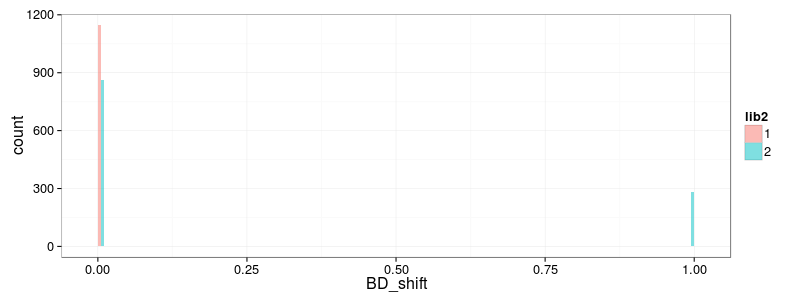

In [179]:
%%R -i workDir -w 800 -h 300

setwd(workDir)

tbl = read.csv('ampFrags_kde_dif_incorp_BD-shift.txt', sep='\t')

tbl$lib2 = as.character(tbl$lib2)
ggplot(tbl, aes(BD_shift, fill=lib2)) +
    geom_histogram(position='dodge', alpha=0.5, binwidth=0.01) +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

# Simulating gradient fractions

In [32]:
%time !cd $workDir; \
    SIPSim fractions \
    comm.txt \
    > fracs.txt

CPU times: user 20 ms, sys: 20 ms, total: 40 ms
Wall time: 4.09 s


## Plotting fractions

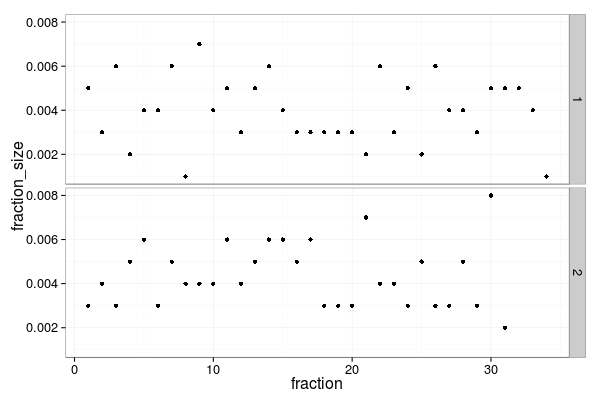

In [39]:
%%R -i workDir -w 600 -h 400
setwd(workDir)

tbl = read.delim('fracs.txt', sep='\t')

ggplot(tbl, aes(fraction, fraction_size)) +
    geom_point() +
    facet_grid(library ~ .) +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

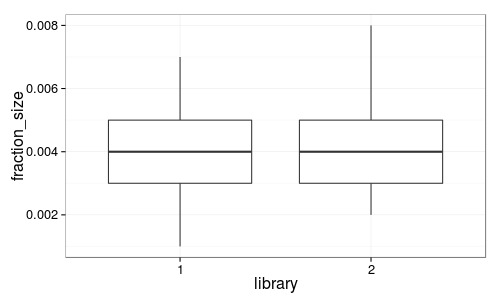

In [40]:
%%R -w 500 -h 300
tbl$library = as.character(tbl$library)

ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot() +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating an OTU table

In [126]:
%time !cd $workDir; \
    SIPSim OTU_table \
    ampFrags_kde_dif_incorp.pkl \
    comm.txt \
    fracs.txt \
    --abs 1e10 \
    --np 8 \
    > OTU_abs1e10.txt

Loading files...
Simulating OTUs...
Processing library: "1"
  Processing taxon: "Xylella_fastidiosa_subsp_fastidiosa_GB514"
   taxon abs-abundance:  680170376
  Processing taxon: "Clostridium_pasteurianum_DSM_525_ATCC_6013"
   taxon abs-abundance:  45090190
  Processing taxon: "Pseudomonas_syringae_pv_tomato_str_DC3000"
   taxon abs-abundance:  27108778
  Processing taxon: "Enterobacter_aerogenes_KCTC_2190"
   taxon abs-abundance:  18221944
  Processing taxon: "Acidaminococcus_intestini_RyC-MR95"
   taxon abs-abundance:  12117695
  Processing taxon: "Clostridium_novyi_NT"
   taxon abs-abundance:  26828964
  Processing taxon: "Rickettsia_typhi_str_TH1527"
   taxon abs-abundance:  17983866
  Processing taxon: "Burkholderia_vietnamiensis_G4"
   taxon abs-abundance:  9269019
  Processing taxon: "Methylobacterium_nodulans_ORS_2060"
   taxon abs-abundance:  11966676
  Processing taxon: "Candidatus_Sulcia_muelleri_PSPU"
   taxon abs-abundance:  43772319
  Processing taxon: "Streptococcus_oral

## Plotting taxon abundances

In [127]:
%%R -i workDir

# loading file
tbl = read.delim('OTU_abs1e10.txt', sep='\t')

#tbl$abs_abund = as.numeric(gsub('.+-nS_A|\\.txt\\.[0-9]+', '', rownames(tbl)))

tbl = tbl %>% 
    filter(!grepl('inf', fraction, ignore.case=T)) %>%
    separate(fraction, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min != 1.795)

In [128]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

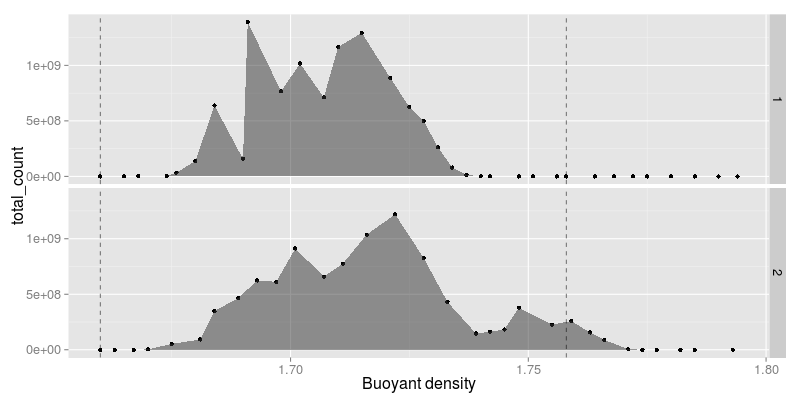

In [129]:
%%R -w 800 -h 400
# plotting absolute abundances

tbl.s = tbl %>%
    group_by(library, BD_min, library) %>%
    summarize(total_count = sum(count))


## plot
p = ggplot(tbl.s, aes(BD_min, total_count)) +
    geom_point() +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme( 
        text = element_text(size=16) 
    )
p

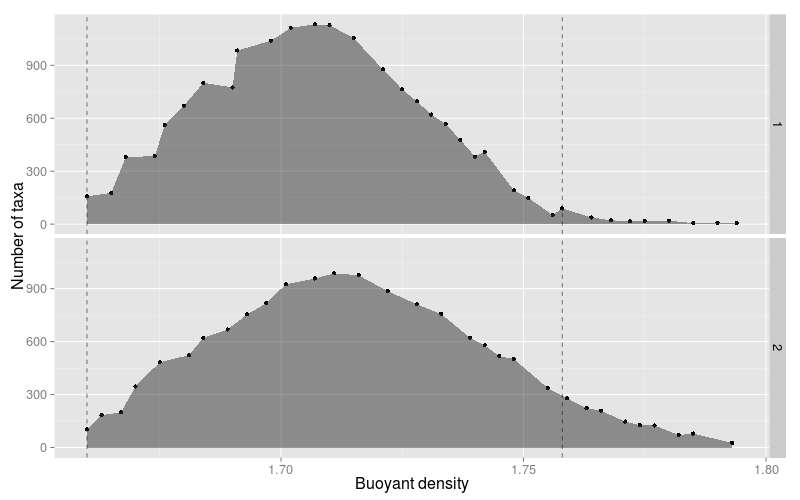

In [130]:
%%R -w 800 -h 500
# plotting number of taxa at each BD

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(library, BD_min) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_min, n_taxa)) +
    geom_point() +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(library ~ .) +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

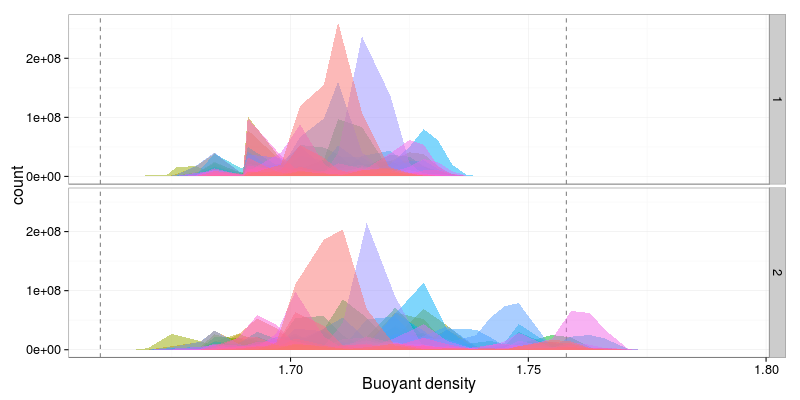

In [131]:
%%R -w 800 -h 400
# plotting relative abundances

## plot
p = ggplot(tbl, aes(BD_min, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

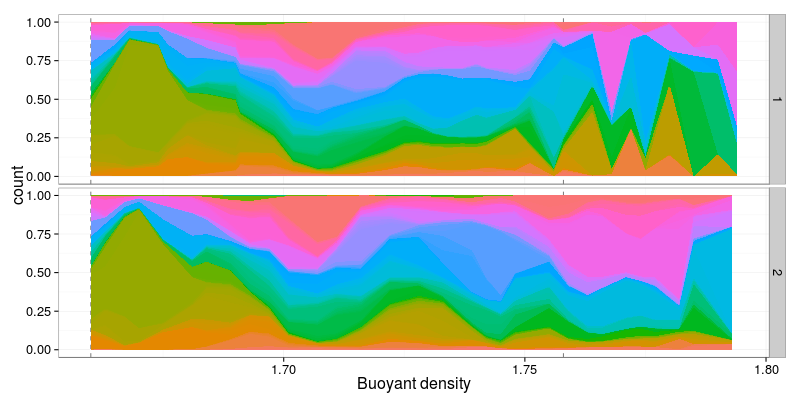

In [132]:
%%R -w 800 -h 400
p + geom_area(stat='identity', position='fill')

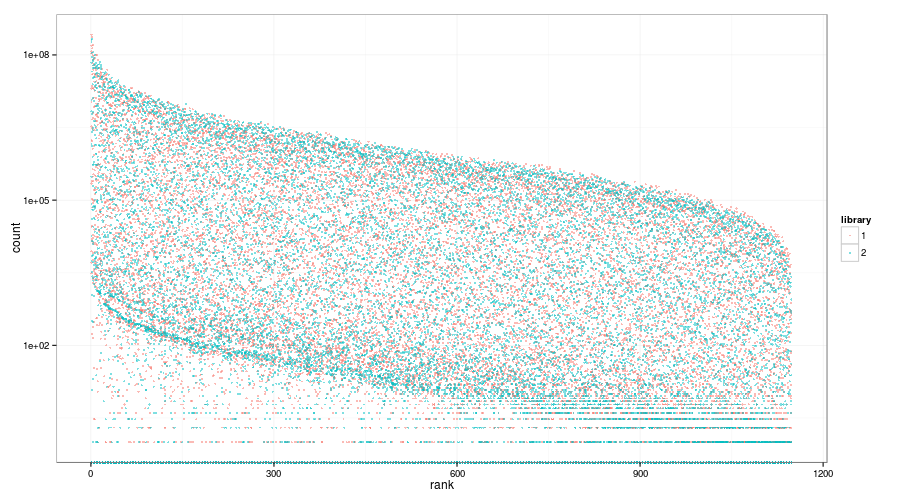

In [133]:
%%R -w 900 -h 500
# rank-abundance
tbl.s = tbl %>% 
    group_by(taxon) %>%
    summarize(total_count = sum(count)) %>%
    mutate(rank = min_rank(desc(total_count))) %>%
    arrange(rank)

tbl.j = inner_join(tbl, tbl.s, c('taxon' = 'taxon'))

tbl.j$library = as.character(tbl.j$library)

ggplot(tbl.j, aes(rank, count, color=library)) +
    geom_point(alpha=0.5, size=1) +
    scale_y_log10() +
    theme_bw()

# Subsampling from the OTU table 

* simulating sequencing of the DNA pool

In [135]:
%time !cd $workDir; \
    SIPSim OTU_subsample \
    --dist_params low:20000,high:20000 \
    OTU_abs1e10.txt \
    > OTU_n2_abs1e10_sub20000.txt

CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 2.97 s


# Making a wide OTU table

In [136]:
%time !cd $workDir; \
    SIPSim OTU_wideLong -w \
    OTU_n2_abs1e10_sub20000.txt \
    > OTU_n2_abs1e10_sub20000_w.txt

CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 1.19 s


# Making metadata (phyloseq: sample_data)

In [137]:
%time !cd $workDir; \
    SIPSim OTU_sampleData \
    OTU_n2_abs1e10_sub20000.txt \
    > OTU_n2_abs1e10_sub20000_meta.txt

CPU times: user 4 ms, sys: 12 ms, total: 16 ms
Wall time: 1.16 s


# Community analysis

## Phyloseq

In [330]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# making phyloseq object from OTU table
phyloseq_make.r \
    OTU_n2_abs1e10_sub20000_w.txt \
    -s OTU_n2_abs1e10_sub20000_meta.txt \
    > OTU_n2_abs1e10_sub20000.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs1e10_sub20000.physeq \
    OTU_n2_abs1e10_sub20000_bray-NMDS.pdf    
## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    OTU_n2_abs1e10_sub20000.physeq \
    --BD_min 1.71 --BD_max 1.75 --occur 0.25 \
    > OTU_n2_abs1e10_sub20000_filt.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs1e10_sub20000_filt.physeq \
    OTU_n2_abs1e10_sub20000_filt_bray-NMDS.pdf
    
convert OTU_n2_abs1e10_sub20000_bray-NMDS.pdf OTU_n2_abs1e10_sub20000_bray-NMDS.png
convert OTU_n2_abs1e10_sub20000_filt_bray-NMDS.pdf OTU_n2_abs1e10_sub20000_filt_bray-NMDS.png

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1956647 
Run 1 stress 0.1988998 
Run 2 stress 0.2048481 
Run 3 stress 0.1964918 
Run 4 stress 0.2082582 
Run 5 stress 0.1921649 
... New best solution
... procrustes: rmse 0.08502894  max resid 0.2496567 
Run 6 stress 0.1970505 
Run 7 stress 0.1999063 
Run 8 stress 0.1896695 
... New best solution
... procrustes: rmse 0.08327524  max resid 0.3864499 
Run 9 stress 0.1949182 
Run 10 stress 0.1979453 
Run 11 stress 0.190961 
Run 12 stress 0.1862421 
... New best solution
... procrustes: rmse 0.06528776  max resid 0.3897962 
Run 13 stress 0.1801314 
... New best solution
... procrustes: rmse 0.05740628  max resid 0.1777582 
Run 14 stress 0.183684 
Run 15 stress 0.2039565 
Run 16 stress 0.1973303 
Run 17 stress 0.1901987 
Run 18 stress 0.1931826 
Run 19 stress 0.1834925 
Run 20 stress 0.1915064 
Square root transformation
Wisconsin double standardization
Run 0 stress 0.1152031 
Run 1 stress 0.1291542 
Run 2 stress 0.

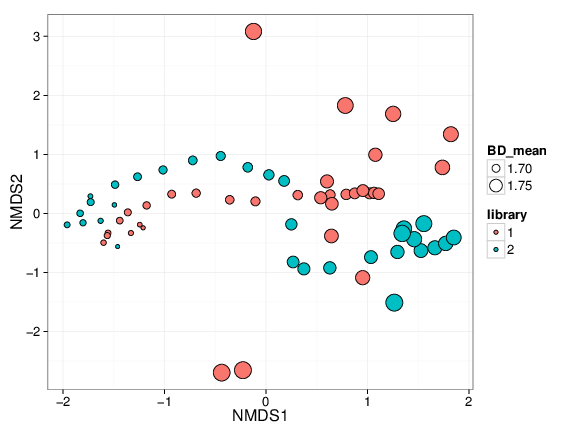

In [331]:
os.chdir(workDir)
Image(filename='OTU_n2_abs1e10_sub20000_bray-NMDS.png') 

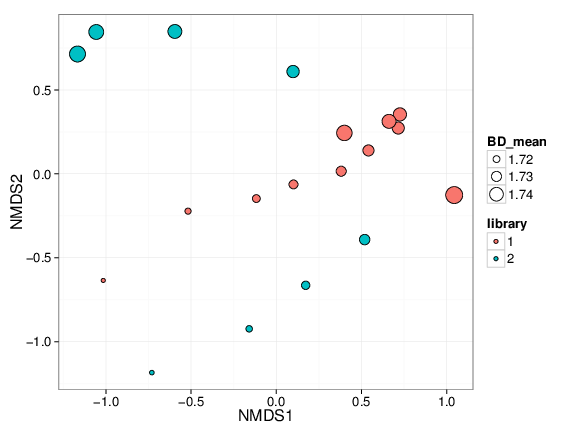

In [332]:
os.chdir(workDir)
Image(filename='OTU_n2_abs1e10_sub20000_filt_bray-NMDS.png')

## DESeq2

In [333]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# Chuck's method

## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs1e10_sub20000_filt.physeq \
    --log2 0.25 \
    > OTU_n2_abs1e10_sub20000_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    ampFrags_kde_dif_incorp_BD-shift.txt \
    OTU_n2_abs1e10_sub20000_DESeq2 \
    --padjBH 0.1

converting counts to integer mode
Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 32 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx_data.csv
File written: DESeq2-cMtx
File written: DESeq2-cMtx_table.csv
File written: DESeq2-cMtx_overall.csv
File written: DESeq2-cMtx_byClass.csv


In [334]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# altHypothesis = 'greater'

## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs1e10_sub20000_filt.physeq \
    --log2 0.25 \
    --hypo greater \
    > OTU_n2_abs1e10_sub20000_DESeq2
    
## Confusion matrix
DESeq2_confuseMtx.r \
    ampFrags_kde_dif_incorp_BD-shift.txt \
    OTU_n2_abs1e10_sub20000_DESeq2 \
    --padj 0.1    

converting counts to integer mode
Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 32 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx_data.csv
File written: DESeq2-cMtx
File written: DESeq2-cMtx_table.csv
File written: DESeq2-cMtx_overall.csv
File written: DESeq2-cMtx_byClass.csv


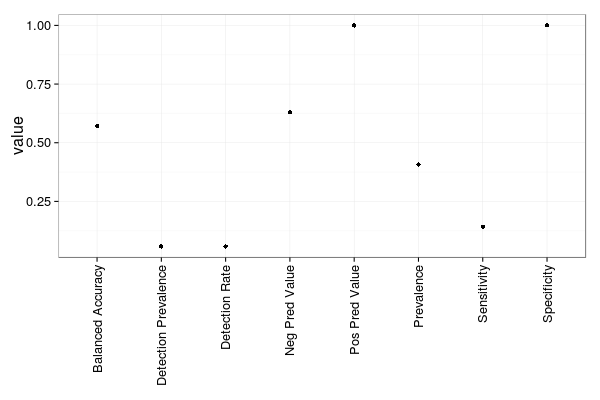

In [335]:
%%R -i workDir -w 600 -h 400

setwd(workDir)

byClass = read.csv('DESeq2-cMtx_byClass.csv')

ggplot(byClass, aes(X, byClass)) +
    geom_point() +
    labs(y='value') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
        axis.title.x=element_blank()
        )

# Conclusions


* BD_shift and OTU_table are memory intensive & must use less cores
* DESeq2 sensitivity is low, but specificity is perfect

## Plotting results of DESeq2

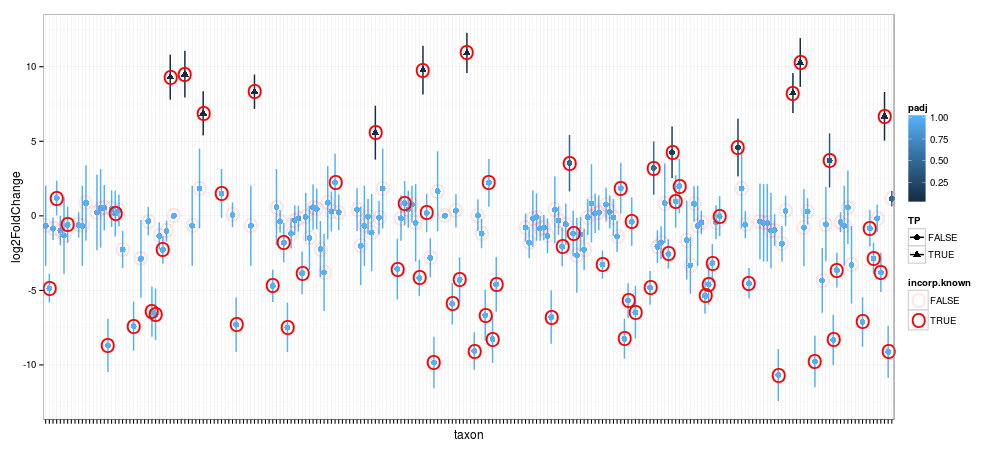

In [336]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

tbl = read.csv('DESeq2-cMtx_data.csv')

tbl = tbl %>%
    mutate(TP = padj < 0.1)

tbl.FN = tbl %>% 
    filter(incorp.known == TRUE & incorp.pred == FALSE) 

ggplot(tbl, aes(taxon, log2FoldChange, shape=TP, color=padj, ymin=log2FoldChange - lfcSE, ymax=log2FoldChange + lfcSE)) +
    geom_pointrange(size=0.7) +
    geom_point(shape='O', aes(alpha=incorp.known), size=7, color='red') +
    theme_bw() +
    theme(
        axis.text.x = element_blank() #element_text(angle=90, hjust=1, vjust=0.4)
        )

__Notes:__

* Red circles = true positives

* False positives should increase with taxon GC 
  * Higher GC moves 100% incorporators too far to the right the gradient for the 'heavy' BD range of 1.71-1.75

# Plotting abundance distribution of True Positive taxa (actual incorporators) 

In [343]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

tbl.ds = read.csv('DESeq2-cMtx_data.csv')

# loading file
tbl.otu = read.delim('OTU_abs1e10.txt', sep='\t')

tbl.otu = tbl.otu %>% 
    filter(!grepl('inf', fraction, ignore.case=T)) %>%
    separate(fraction, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min != 1.795)

tbl.j = inner_join(tbl.otu, tbl.ds, c('taxon' = 'taxon'))



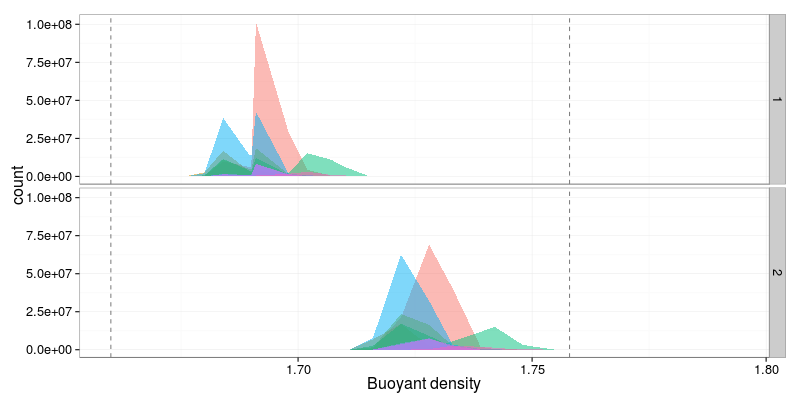

In [347]:
%%R -w 800 -h 400
# plotting relative abundances

tbl.j.TP = tbl.j %>% 
    filter(incorp.known == TRUE & incorp.pred == TRUE) 


## plot
p = ggplot(tbl.j.TP, aes(BD_min, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

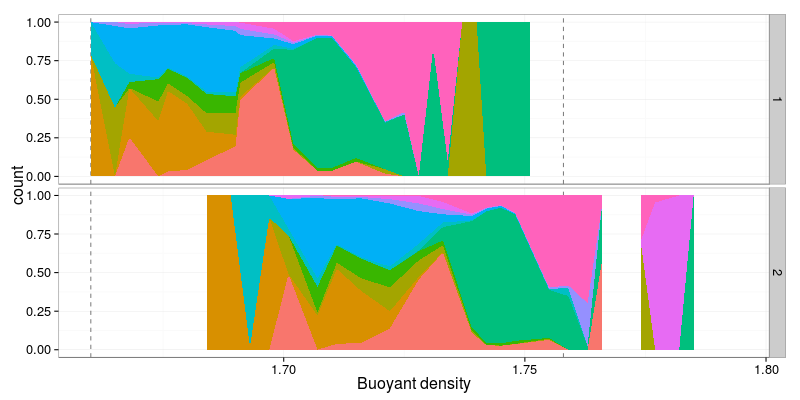

In [348]:
%%R -w 800 -h 400
p + geom_area(stat='identity', position='fill')

# Plotting abundance distribution of False Negative taxa (actual incorporators) 

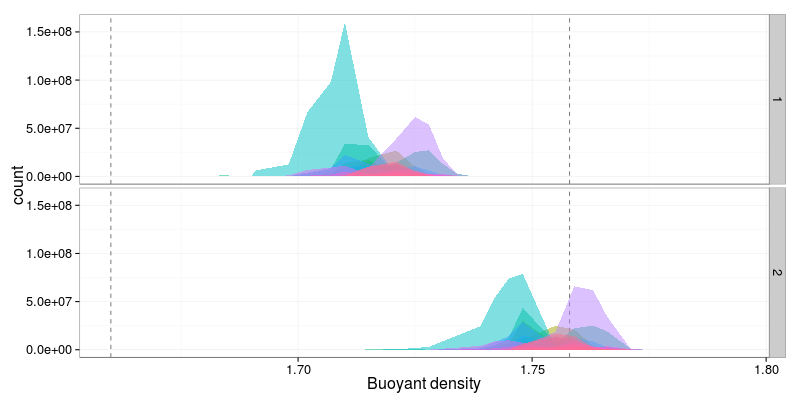

In [349]:
%%R -w 800 -h 400
# plotting relative abundances

tbl.j.FN = tbl.j %>% 
    filter(incorp.known == TRUE & incorp.pred == FALSE) 

## plot
p = ggplot(tbl.j.FN, aes(BD_min, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

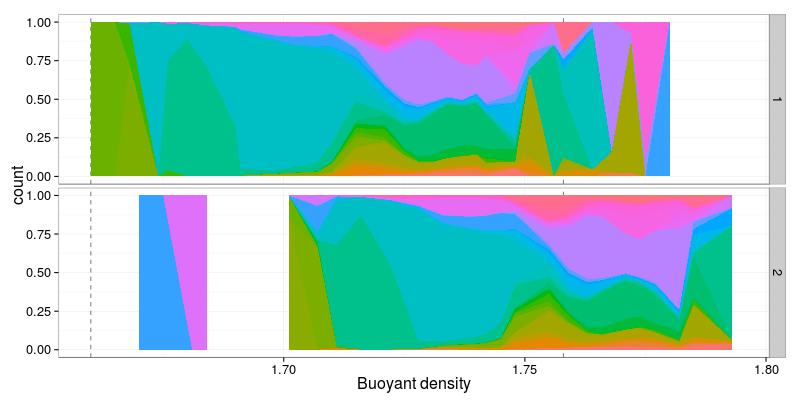

In [350]:
%%R -w 800 -h 400
p + geom_area(stat='identity', position='fill')

## Conclusions

* For 100% incorporation, the 'heavy' BD range of 1.71-1.75 does not encompass most of the incorporator abundance.
  * This results in negative log2fc

# Enrichment of TP for abundant incorporators?

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [425]:
%%R -i workDir

setwd(workDir)

tbl.ds = read.csv('DESeq2-cMtx_data.csv')
tbl.otu = read.delim('OTU_abs1e10.txt', sep='\t')

In [432]:
%%R
tbl.ds %>% filter(incorp.known==TRUE & incorp.pred==FALSE)

   lib1 lib2                                                  taxon  BD_shift
1    NA    2                             Sphingomonas_wittichii_RW1 0.9997093
2    NA    2                     Methylovorus_glucosetrophus_SIP3-4 0.9821967
3    NA    2                                Rhodococcus_jostii_RHA1 0.9999748
4    NA    2                            Pseudomonas_knackmussii_B13 0.9997856
5    NA    2                          Raoultella_ornithinolytica_B6 0.9984159
6    NA    2                        Pelagibacterium_halotolerans_B2 0.9999556
7    NA    2                      Thermomonospora_curvata_DSM_43183 0.9998354
8    NA    2                               Burkholderia_cepacia_GG4 0.9997990
9    NA    2                     Candidatus_Symbiobacter_mobilis_CR 0.9993642
10   NA    2                             Spiribacter_salinus_M19-40 0.9999086
11   NA    2                      Hyphomicrobium_nitrativorans_NL23 0.9998554
12   NA    2            Clavibacter_michiganensis_subsp_sepedoni

In [426]:
%%R
# OTU total counts
tbl.otu.sum = tbl.otu %>%
    group_by(library, taxon) %>%
    summarize(total_count = sum(count))
tbl.otu.sum %>% head

Source: local data frame [6 x 3]
Groups: library

  library                                taxon total_count
1       1       Acaryochloris_marina_MBIC11017     8750717
2       1       Acetobacterium_woodii_DSM_1030     1342396
3       1 Acetobacter_pasteurianus_IFO_3283-12      310463
4       1    Acetohalobium_arabaticum_DSM_5501     5535330
5       1         Acholeplasma_laidlawii_PG-8A      420897
6       1        Achromobacter_xylosoxidans_A8     2350927


In [427]:
%%R
# 
label.tp.fn = function(known, pred){
    if(is.na(known) | is.na(pred)){
        return(NA)
        } else
    if(known==TRUE & pred==TRUE){
        return('TP')
        } else
    if(known==FALSE & pred==TRUE){
        return('FN')
        } else {
        return(NA)
        }
    }

tbl.ds.tp.fn = tbl.ds %>% 
    mutate(tp.fn = mapply(label.tp.fn, incorp.known, incorp.pred)) %>%
    filter(! is.na(tp.fn))

tbl.tp.fn = inner_join(tbl.ds.tp.fn, tbl.otu.sum, c('taxon' = 'taxon')) 
tbl.tp.fn %>% head

  lib1 lib2                                           taxon  BD_shift
1   NA    2       Thermoanaerobacterium_xylanolyticum_LX-11 0.9998544
2   NA    2       Thermoanaerobacterium_xylanolyticum_LX-11 0.9998544
3   NA    2 Candidatus_Kinetoplastibacterium_galatii_TCC219 0.9999007
4   NA    2 Candidatus_Kinetoplastibacterium_galatii_TCC219 0.9999007
5   NA    2           Caldicellulosiruptor_lactoaceticus_6A 0.9996414
6   NA    2           Caldicellulosiruptor_lactoaceticus_6A 0.9996414
  incorp.known  baseMean log2FoldChange    lfcSE     stat       pvalue
1         TRUE  10.91934      10.282914 1.634740 6.137316 4.196364e-10
2         TRUE  10.91934      10.282914 1.634740 6.137316 4.196364e-10
3         TRUE  16.96729       6.873937 1.479554 4.476983 3.785271e-06
4         TRUE  16.96729       6.873937 1.479554 4.476983 3.785271e-06
5         TRUE 131.76975       9.302946 1.506294 6.010078 9.271685e-10
6         TRUE 131.76975       9.302946 1.506294 6.010078 9.271685e-10
          pad

In [428]:
%%R
# how many TP & FN?
tbl.tp.fn %>% 
    group_by(library, tp.fn) %>%
    summarize(n = n())

Source: local data frame [2 x 3]
Groups: library

  library tp.fn  n
1       1    TP 10
2       2    TP 10


***

# Sandbox

In [389]:
from IPython.display import Image

In [413]:
tmpDir = '/home/nick/notebook/SIPSim/t/genome100/'

In [422]:
!cd $tmpDir; \
    SIPSim KDE_plot \
    ampFrag_skewN90-25-n5-nS_dif_kde.pkl \
    -n 3 -o KDE_1d_n3.png \
    --xMin 1.66 --xMax 1.8 --logY 2

Processing KDE for taxon: "Acidovorax_citrulli_AAC00-1"
Processing KDE for taxon: "Aeromonas_salmonicida_subsp_salmonicida_A449"
Processing KDE for taxon: "Aeromonas_veronii_B565"
File written: "KDE_1d_n3.png"


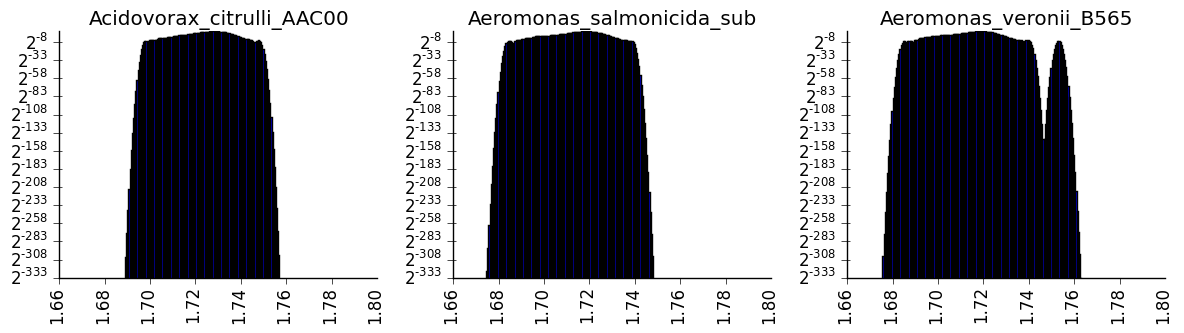

In [423]:
Image('/home/nick/notebook/SIPSim/t/genome100/KDE_1d_n3.png', retina=True)

In [416]:
!cd $tmpDir; \
    SIPSim KDE_plot \
    ampFrag_skewN90-25-n5-nS_dif_kde.pkl \
    -n 9 -o KDE_1d_n9_log10.png \
    --xMin 1.66 --xMax 1.8 --logY 10

Processing KDE for taxon: "Acidovorax_citrulli_AAC00-1"
Processing KDE for taxon: "Aeromonas_salmonicida_subsp_salmonicida_A449"
Processing KDE for taxon: "Aeromonas_veronii_B565"
Processing KDE for taxon: "Alicyclobacillus_acidocaldarius_subsp_acidocaldarius_DSM_446"
Processing KDE for taxon: "Anaplasma_centrale_str_Israel"
Processing KDE for taxon: "Bacillus_subtilis_PY79"
Processing KDE for taxon: "Bartonella_grahamii_as4aup"
Processing KDE for taxon: "Bifidobacterium_dentium_Bd1"
Processing KDE for taxon: "Borrelia_garinii_PBi"
File written: "KDE_1d_n9_log10.png"


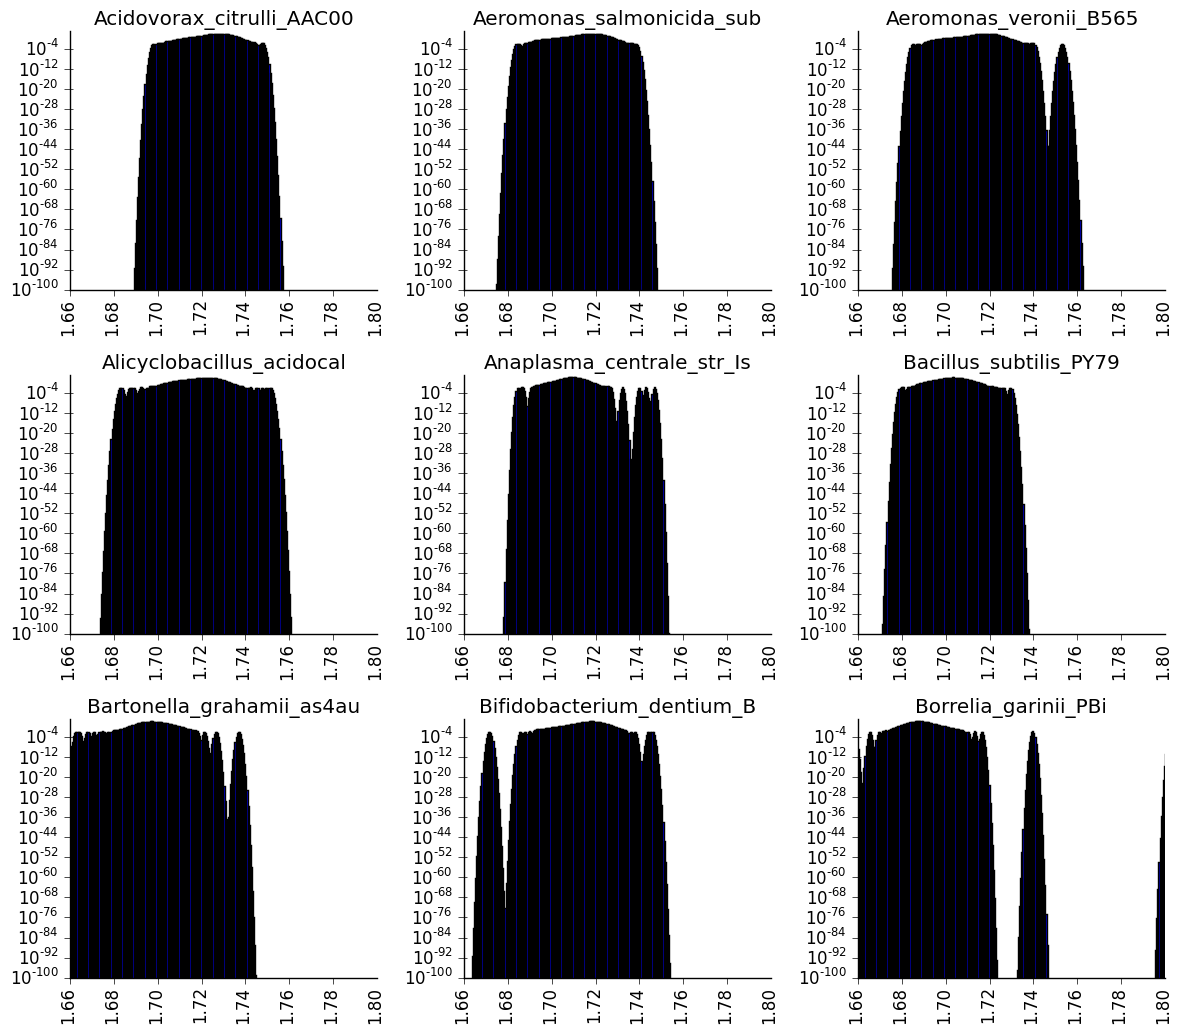

In [417]:
Image('/home/nick/notebook/SIPSim/t/genome100/KDE_1d_n9_log10.png', retina=True)

In [418]:
!cd $tmpDir; \
    SIPSim KDE_plot \
    ampFrag_skewN90-25-n5-nS_dif_kde.pkl \
    -o KDE_1d_n100_log10.png \
    --xMin 1.66 --xMax 1.8 --logY 10

Processing KDE for taxon: "Acidovorax_citrulli_AAC00-1"
Processing KDE for taxon: "Aeromonas_salmonicida_subsp_salmonicida_A449"
Processing KDE for taxon: "Aeromonas_veronii_B565"
Processing KDE for taxon: "Alicyclobacillus_acidocaldarius_subsp_acidocaldarius_DSM_446"
Processing KDE for taxon: "Anaplasma_centrale_str_Israel"
Processing KDE for taxon: "Bacillus_subtilis_PY79"
Processing KDE for taxon: "Bartonella_grahamii_as4aup"
Processing KDE for taxon: "Bifidobacterium_dentium_Bd1"
Processing KDE for taxon: "Borrelia_garinii_PBi"
Processing KDE for taxon: "Bradyrhizobium_diazoefficiens_USDA_110"
Processing KDE for taxon: "Brevibacillus_brevis_NBRC_100599"
Processing KDE for taxon: "Caldicellulosiruptor_kristjanssonii_I77R1B"
Processing KDE for taxon: "Caldicellulosiruptor_saccharolyticus_DSM_8903"
Processing KDE for taxon: "Campylobacter_coli_RM1875"
Processing KDE for taxon: "Campylobacter_fetus_subsp_venerealis_cfvi03_293"
Processing KDE for taxon: "Candidatus_Liberibacter_asiaticu

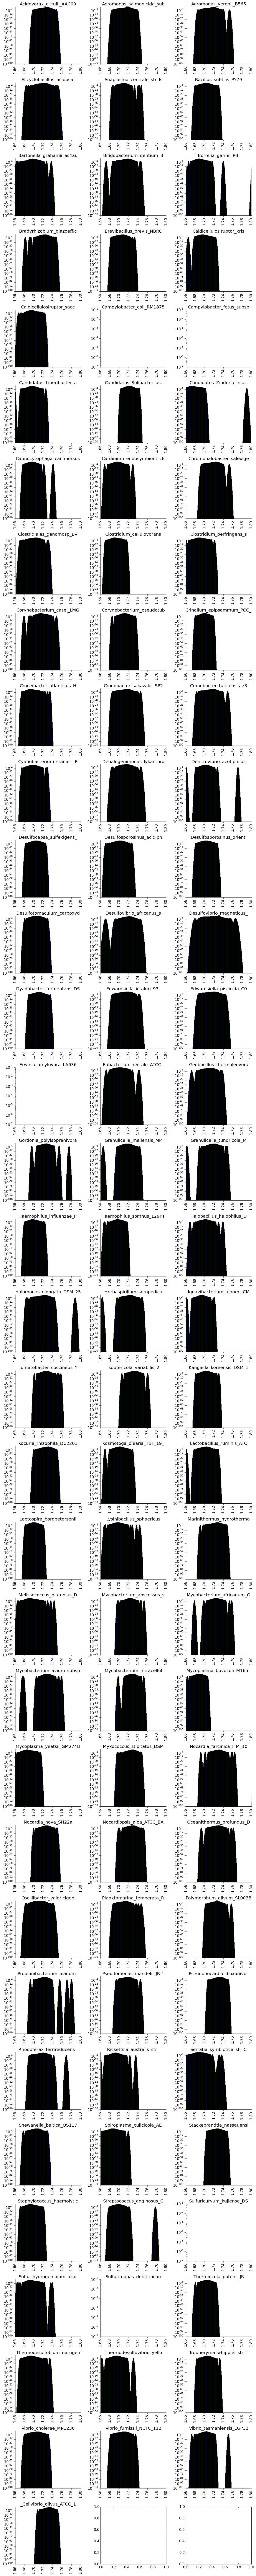

In [419]:
Image('/home/nick/notebook/SIPSim/t/genome100/KDE_1d_n100_log10.png', retina=True)